In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sklearn.cluster import KMeans
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Datasets

In [3]:
dataset = 1
# Load the training dataset
if dataset == 1:
    # Zainil's path
    folder_dataset = datasets.ImageFolder(root=r"C:\Users\deepm\OneDrive\Desktop\Uni Siegen Course\Zainil\Sem 4\RAML\Work\SiameseNeuralNetwork\data\faces\training")
    folder_dataset_test = datasets.ImageFolder(root=r"C:\Users\deepm\OneDrive\Desktop\Uni Siegen Course\Zainil\Sem 4\RAML\Work\SiameseNeuralNetwork\data\faces\testing")
    #Nisarg's path
    # folder_dataset = datasets.ImageFolder(root=r"D:\Uni_Sem4\SiameseNeuralNetwork\data\faces\training")
    # folder_dataset_test = datasets.ImageFolder(root=r"D:\Uni_Sem4\SiameseNeuralNetwork\data\faces\testing/")
    # Resize the images and transform to tensors
    transformation = transforms.Compose([transforms.Resize((100,100)),
                                        transforms.ToTensor()
                                        ])
    d_no_epochs = 50
    d_batch_size = 64
    # from paper
    def1_margin = 2
    def2_margin = 0.1
elif dataset == 2:
    folder_dataset = datasets.ImageFolder(root=r"D:\Uni_Sem4\SiameseNeuralNetwork\data\MNIST_Data\training")
    folder_dataset_test = datasets.ImageFolder(root=r"D:\Uni_Sem4\SiameseNeuralNetwork\data\MNIST_Data\testing")
    # Resize the images and transform to tensors
    transformation = transforms.Compose([transforms.Resize((24,24)),
                                        transforms.ToTensor()
                                        ])
    d_no_epochs = 2
    d_batch_size = 1024
    d_margin = 2.0

In [4]:
# Creating some helper functions
def imshow(img, text=None):
    plt.figure(figsize=(8,4))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [5]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None, rand=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.rand = rand
        self.files = iter(self.imageFolderDataset.imgs)
        self.current_file = next(self.files)

    def __getitem__(self,index):
        if self.rand:
            anchor_tuple = random.choice(self.imageFolderDataset.imgs)
            while True:
                #Look untill the same class image is found
                positive_tuple = random.choice(self.imageFolderDataset.imgs) 
                if anchor_tuple[1] == positive_tuple[1]:
                    break


            while True:
                #Look untill a different class image is found
                negative_tuple = random.choice(self.imageFolderDataset.imgs) 
                if anchor_tuple[1] != negative_tuple[1]:
                    break

            while True:
                # Look untill a completely different class image is found
                edgecase_tuple = random.choice(self.imageFolderDataset.imgs)
                if (edgecase_tuple[1] != negative_tuple[1]) and (edgecase_tuple[1] != positive_tuple[1]) and (edgecase_tuple[1] != anchor_tuple[1]):
                    break

            anchor = Image.open(anchor_tuple[0])
            positive = Image.open(positive_tuple[0])
            negative = Image.open(negative_tuple[0])
            edgecase = Image.open(edgecase_tuple[0])
            label = [anchor_tuple[0].split('\\')[-2]]
        
        else:
            anchor_tuple = self.current_file
            while True:
                #Look untill the same class image is found
                positive_tuple = random.choice(self.imageFolderDataset.imgs) 
                if anchor_tuple[1] == positive_tuple[1]:
                    break


            while True:
                #Look untill a different class image is found
                negative_tuple = random.choice(self.imageFolderDataset.imgs) 
                if anchor_tuple[1] != negative_tuple[1]:
                    break

            while True:
                # Look untill a completely different class image is found
                edgecase_tuple = random.choice(self.imageFolderDataset.imgs)
                if (edgecase_tuple[1] != negative_tuple[1]) and (edgecase_tuple[1] != positive_tuple[1]) and (edgecase_tuple[1] != anchor_tuple[1]):
                    break

            anchor = Image.open(anchor_tuple[0])
            positive = Image.open(positive_tuple[0])
            negative = Image.open(negative_tuple[0])
            edgecase = Image.open(edgecase_tuple[0])
            label = [anchor_tuple[0].split('\\')[-2]]
            self.current_file = next(self.files)    

        anchor = anchor.convert("L")
        positive = positive.convert("L")
        negative = negative.convert("L")
        edgecase =edgecase.convert("L")

        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
            edgecase = self.transform(edgecase)
        
        
        return anchor, positive, negative, edgecase, label
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    
    def get_current_value(self):
        if self.index >= len(self.iterable):
            raise StopIteration
        return self.iterable[self.index]

In [6]:
#Download the dataset from our [GitHub](https://github.com/maticvl/dataHacker/blob/master/DATA/at%26t.zip) profile, just by running the code below.

In [7]:
# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

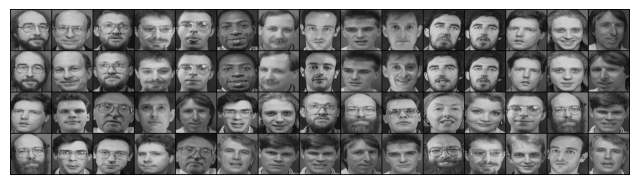

In [8]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=15)

# Extract one batch
example_batch = next(iter(vis_dataloader))
# Example batch is a list containing 3x11 images
concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2], example_batch[3]),0)
imshow(torchvision.utils.make_grid(concatenated,nrow=15))
# print(example_batch[3])


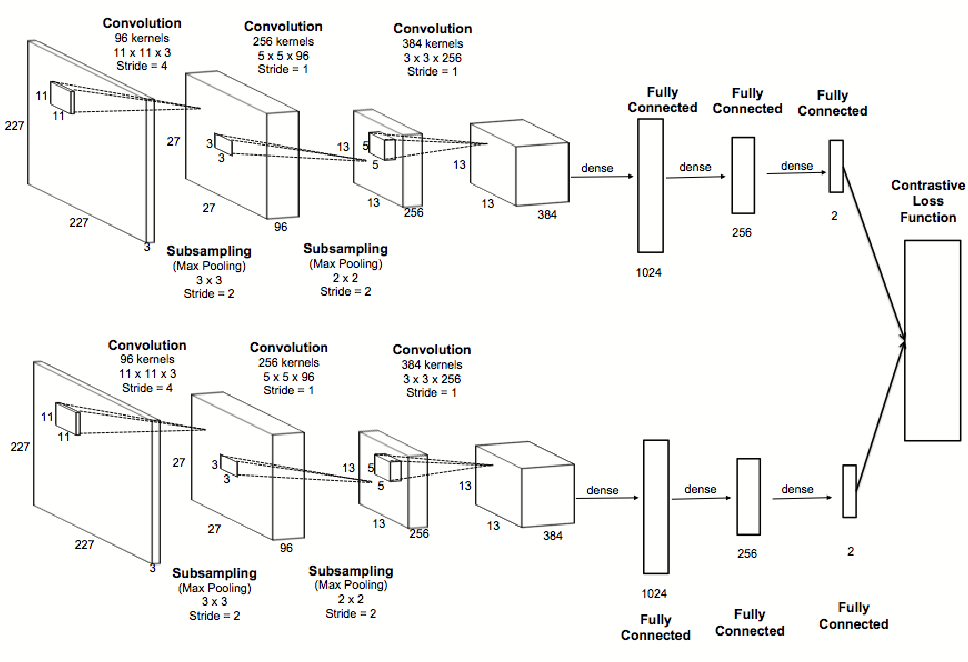

In [9]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        if dataset ==1:
            super(SiameseNetwork, self).__init__()
            # Setting up the Sequential of CNN Layers
            self.cnn1 = nn.Sequential(
                nn.Conv2d(1, 96, kernel_size=11,stride=4),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, stride=2),
                
                nn.Conv2d(96, 256, kernel_size=5, stride=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=2),

                nn.Conv2d(256, 384, kernel_size=3,stride=1),
                nn.ReLU(inplace=True)
            )

            # Setting up the Fully Connected Layers
            self.fc1 = nn.Sequential(
                nn.Linear(384, 1024),
                nn.ReLU(inplace=True),
                
                nn.Linear(1024, 256),
                nn.ReLU(inplace=True),
                
                nn.Linear(256,2)
            )
        elif dataset==2:
            super(SiameseNetwork, self).__init__()
            self.cnn1 = nn.Sequential(
                nn.Conv2d(1, 32, 3),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
            self.fc1 = nn.Sequential(
                nn.Linear(32*11*11 , 128),
                nn.ReLU(inplace=True),
                nn.Linear(128, 3))

        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, anchor, positive, negative, edgecase):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output_anchor = self.forward_once(anchor)
        output_positive = self.forward_once(positive)
        output_negative = self.forward_once(negative)
        output_edgecase = self.forward_once(edgecase)

        return output_anchor, output_positive, output_negative, output_edgecase

In [10]:
# Define the Quadruplet Loss Function
class QuadrupletLoss(torch.nn.Module):
    def __init__(self, margin1 =def1_margin, margin2 = def2_margin):
        super(QuadrupletLoss, self).__init__()
        self.margin1 = margin1
        self.margin2 = margin2

    
    def forward(self, anchor, positive, negative, edgecase):
        #Calculate the eucidian distance and calculate the Triplet Loss
        distance_positive = F.pairwise_distance(anchor, positive, keepdim=True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim=True)
        distance_edgecase = F.pairwise_distance(negative, edgecase, keepdim= True)

        loss_quadruplet = torch.mean(F.relu((distance_positive - distance_negative + self.margin1)+(distance_positive - distance_edgecase+ self.margin2)))

        return loss_quadruplet

In [11]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=d_batch_size)
print(next(iter(train_dataloader)),'\n')



[tensor([[[[0.2902, 0.2902, 0.3020,  ..., 0.2588, 0.2471, 0.2627],
          [0.2941, 0.2980, 0.2902,  ..., 0.2588, 0.2588, 0.2549],
          [0.2980, 0.2980, 0.2980,  ..., 0.2588, 0.2588, 0.2510],
          ...,
          [0.6824, 0.7059, 0.7216,  ..., 0.3255, 0.2510, 0.1922],
          [0.6902, 0.7176, 0.7216,  ..., 0.4039, 0.4078, 0.3686],
          [0.6941, 0.7176, 0.7294,  ..., 0.4275, 0.4471, 0.4627]]],


        [[[0.4863, 0.4824, 0.4902,  ..., 0.4510, 0.4431, 0.4549],
          [0.4824, 0.4902, 0.4824,  ..., 0.4431, 0.4471, 0.4471],
          [0.4784, 0.4902, 0.4784,  ..., 0.4431, 0.4431, 0.4431],
          ...,
          [0.4353, 0.4745, 0.4510,  ..., 0.3059, 0.3020, 0.2941],
          [0.4627, 0.4392, 0.4784,  ..., 0.2980, 0.2980, 0.2863],
          [0.5490, 0.4078, 0.4902,  ..., 0.2902, 0.2863, 0.3020]]],


        [[[0.2000, 0.1922, 0.1922,  ..., 0.1608, 0.1451, 0.1608],
          [0.2157, 0.1922, 0.1922,  ..., 0.1686, 0.1569, 0.1529],
          [0.2314, 0.1843, 0.2000,  .

In [12]:
net = SiameseNetwork().to(device)
criterion = QuadrupletLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

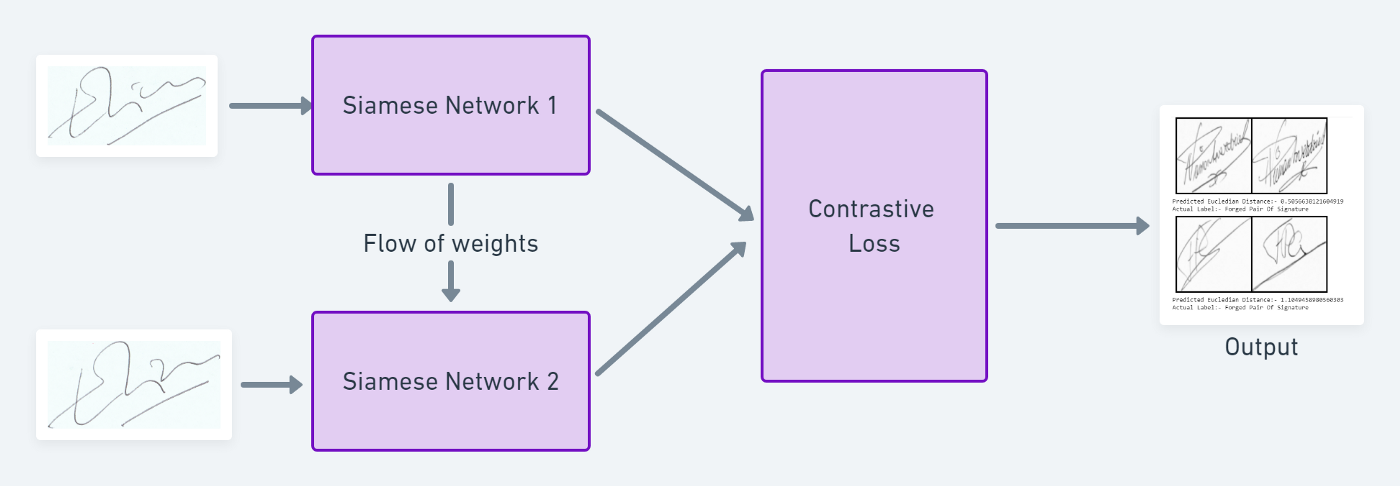

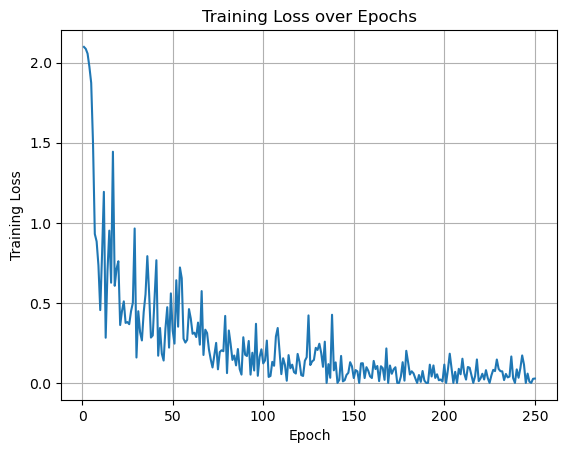

Training finished.


In [13]:
counter = []
loss_history = [] 
iteration_number= 0
# Training loop
for epoch in range(d_no_epochs):
    # Initialize the running loss
    running_loss = 0.0
    
    # Iterate over the batches in the dataloader
    for i, (anchor, positive, negative, edgecase,_)  in enumerate(train_dataloader):
        # print(anchor,positive, negative, edgecase)
        """ """ # Transfer images and labels to the device
        anchor, positive, negative, edgecase = anchor.to(device), positive.to(device), negative.to(device), edgecase.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output_anchor, output_positive, output_negative, output_edgecase = net(anchor, positive, negative,edgecase)
        
        # Calculate the triplet loss
        loss_quadruplet = criterion(output_anchor, output_positive, output_negative, output_edgecase)
        
        # Backward pass and optimization
        loss_quadruplet.backward()
        optimizer.step()
        
        # Update the running loss
        running_loss += loss_quadruplet.item()
        
        # Print the loss every 10 batches
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{d_no_epochs}], Batch [{i+1}/{len(train_dataloader)}], Loss: {running_loss / 10}")
            running_loss = 0.0
        
        # Increment the iteration number
        iteration_number += 1
        
        # Store the loss value
        counter.append(iteration_number)
        loss_history.append(loss_quadruplet.item())
    
    # End of epoch """
    
# Training complete
plt.plot(counter, loss_history)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()
print("Training finished.")


Trainig result visualization

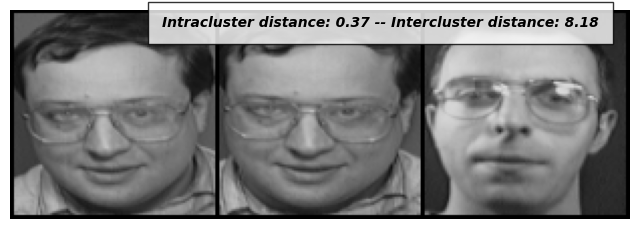

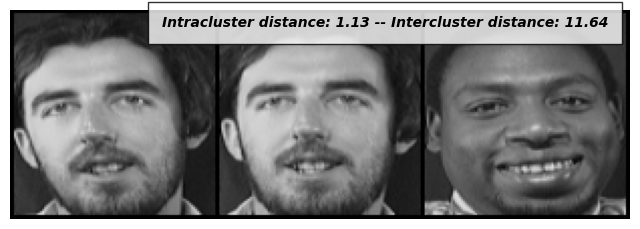

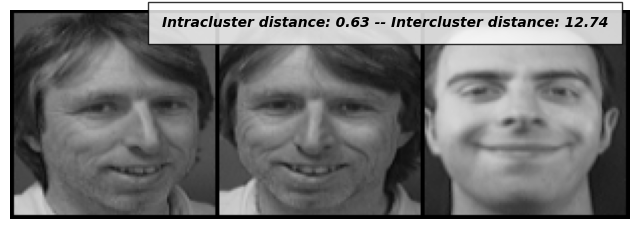

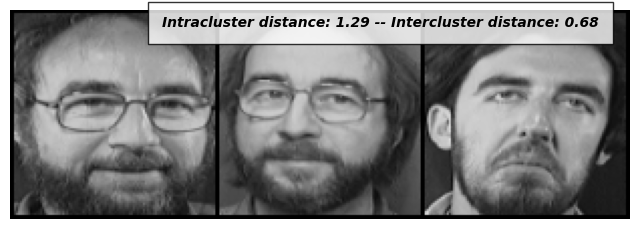

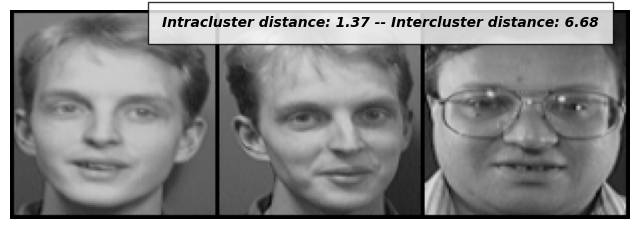

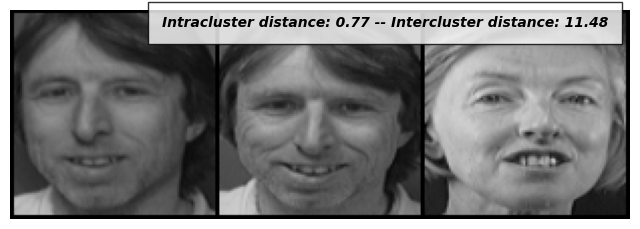

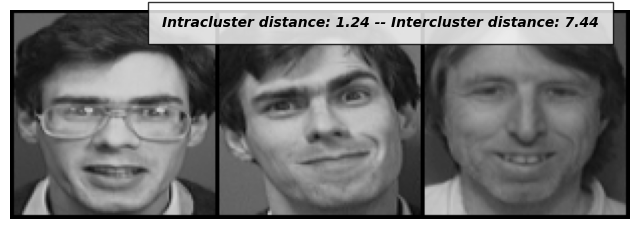

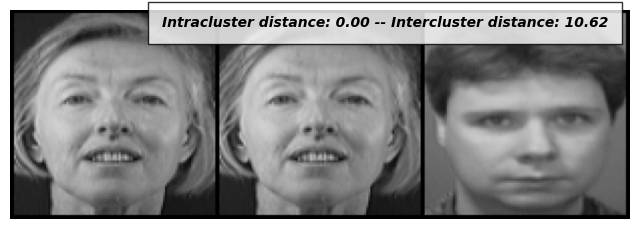

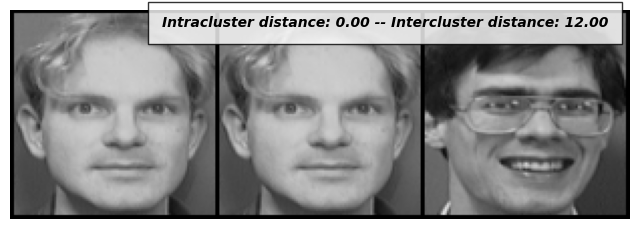

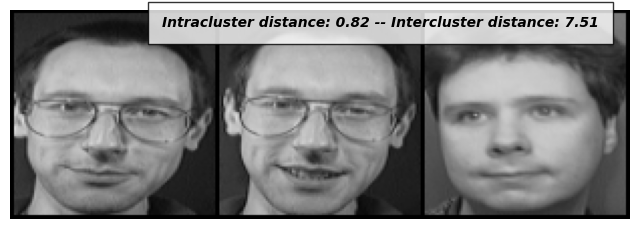

In [14]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)
train_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(train_dataloader)
anchor, positive, negative, _,_ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    anchor, positive, negative, _,_ = next(dataiter)

    # Concatenate the three images together
    concatenated = torch.cat((anchor, positive, negative), 0)
    
    output_anchor, output_positive, output_negative, output_edgecase = net(anchor.to(device), positive.to(device), negative.to(device),edgecase.to(device))
    euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
    euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
    imshow(torchvision.utils.make_grid(concatenated), f'Intracluster distance: {euclidean_distance_positive.item():.2f} -- Intercluster distance: {euclidean_distance_negative.item():.2f}')

Save Parameters


In [15]:
#torch.save({"model_state_dict": net.state_dict(),"optimizer_state_dict": optimizer.state_dict()}, "trained_model.pth")

Visualization of trained network

In [16]:
plot_batch = 5
train_results = []
labels = []
net.eval()
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation,rand=False)
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=d_batch_size)


with torch.no_grad():
    for i,batch in enumerate(vis_dataloader):
        if i >= plot_batch:
            break
        anchor, _, _, _,label = batch
        anchor = anchor.to(device)
        output_anchor = net.forward_once(anchor)
        train_results.append(output_anchor.cpu().numpy())
        labels.append(label[0])

### test data
#siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
#                                        transform=transformation,rand=False)
## Create a simple dataloader just for simple visualization
#vis_dataloader = DataLoader(siamese_dataset,
#                        shuffle=True,
#                        batch_size=d_batch_size)
#
#with torch.no_grad():
#    for i,batch in enumerate(vis_dataloader):
#        if i >= plot_batch:
#            break
#        anchor, _, _, label = batch
#        anchor = anchor.to(device)
#        output_anchor = net.forward_once(anchor)
#        train_results.append(output_anchor.cpu().numpy())
#        labels.append(label[0])
#
#
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
labels=np.array(labels)
combined_data = list(zip(train_results,labels))



Evaluating model on test data:

In [17]:
correct=0
incorrect=0
net.eval()
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation,rand=True)
# Create a simple dataloader just for simple visualization
test_dataloader = DataLoader(siamese_dataset,
                            shuffle=False,
                            batch_size=1)


with torch.no_grad():
    for i,batch in enumerate(test_dataloader):
        anchor, positive, negative, edgecase,label = batch
        # Forward pass
        output_anchor, output_positive, output_negative, output_edgecase = net.forward(anchor.to(device), positive.to(device), negative.to(device), edgecase.to(device))
        euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
        euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
        # Counting correct and incorrecct cases
        if euclidean_distance_positive.item() < euclidean_distance_negative.item():
            correct+=1
        else:
            incorrect+=1
    accuracy = correct/(correct+incorrect)
    print(f'Accuracy of the SNN trained on Quadruplet Loss Function on test data: {accuracy:.2f}')

Accuracy of the SNN trained on Quadruplet Loss Function on test data: 0.83


Visualizing the latent space

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

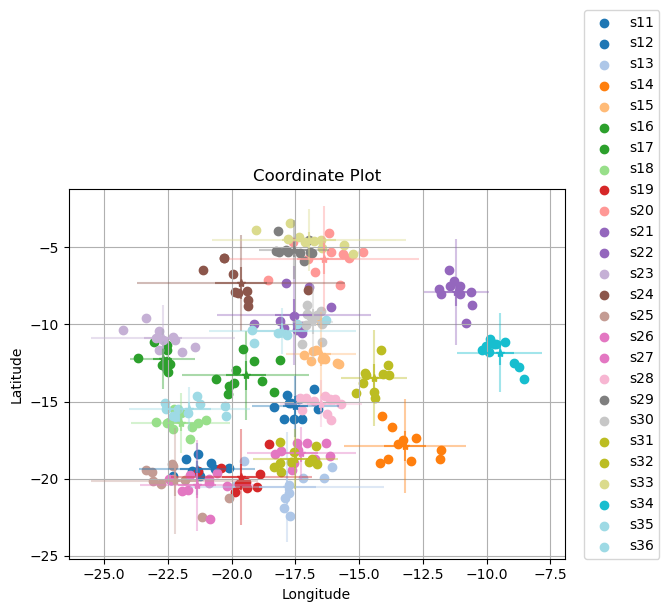

In [18]:
cmap = plt.cm.get_cmap('tab20', len(np.unique([point[1] for point in combined_data])))
fig, ax = plt.subplots()
for label in enumerate(np.unique([point[1] for point in combined_data])):
    points = [data[0] for data in combined_data if data[1]==label[1]]
    ax.scatter([point[0] for point in points], [point[1] for point in points], c=cmap(label[0]), label=label[1])
    points = np.concatenate(points)
    points=points.reshape(-1,2)
    group_means = np.mean(points,axis=0)
    group_std = np.std(points, axis=0)
    group_range = np.ptp(points, axis=0)
    # Plot the mean as a center point
    ax.plot(group_means[0], group_means[1],marker ="*", color=cmap(label[0]))

    # Plot the standard deviation as error bars
    ax.errorbar(group_means[0], group_means[1], xerr=group_std[0], yerr=group_std[1],
            fmt='none', ecolor=cmap(label[0]), alpha=0.7)

    # Plot the range as error bars
    ax.errorbar(group_means[0], group_means[1], xerr=group_range[0], yerr=group_range[1],
            fmt='none', ecolor=cmap(label[0]), alpha=0.4)

ax.grid(True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Coordinate Plot')
plt.legend(loc=(1.04, 0))
